# MoDISco Summarize

Summarise results of MoDISco runs across cell states.

In [1]:
library(ggplot2)
library(patchwork)
library(ggseqlogo)
library(matrixStats)

In [595]:
MODISCO_PATH = "./data/20200518_n76052/bpnet/50k"
CLUSTER_PATTERN = "cluster*"

In [596]:
dirs = list.files(MODISCO_PATH, 
           pattern=CLUSTER_PATTERN, 
          full.names=T)
dirs

[1] "./data/20200518_n76052/bpnet/50k/cluster_idx1" 
 [2] "./data/20200518_n76052/bpnet/50k/cluster_idx10"
 [3] "./data/20200518_n76052/bpnet/50k/cluster_idx11"
 [4] "./data/20200518_n76052/bpnet/50k/cluster_idx12"
 [5] "./data/20200518_n76052/bpnet/50k/cluster_idx13"
 [6] "./data/20200518_n76052/bpnet/50k/cluster_idx14"
 [7] "./data/20200518_n76052/bpnet/50k/cluster_idx15"
 [8] "./data/20200518_n76052/bpnet/50k/cluster_idx16"
 [9] "./data/20200518_n76052/bpnet/50k/cluster_idx17"
[10] "./data/20200518_n76052/bpnet/50k/cluster_idx18"
[11] "./data/20200518_n76052/bpnet/50k/cluster_idx2" 
[12] "./data/20200518_n76052/bpnet/50k/cluster_idx3" 
[13] "./data/20200518_n76052/bpnet/50k/cluster_idx4" 
[14] "./data/20200518_n76052/bpnet/50k/cluster_idx5" 
[15] "./data/20200518_n76052/bpnet/50k/cluster_idx6" 
[16] "./data/20200518_n76052/bpnet/50k/cluster_idx7" 
[17] "./data/20200518_n76052/bpnet/50k/cluster_idx8" 
[18] "./data/20200518_n76052/bpnet/50k/cluster_idx9"

### Load Cell State Config
Use for reordering cell states.

In [597]:
cluster_config = read.table("../../figures_factory/configs/cluster.tsv", comment.char = '', header=T, sep='\t')
cluster_config$colour = as.character(cluster_config$colour)
cluster_config$description = as.character(cluster_config$description)

# order by new_cluster
cluster_config = cluster_config[order(cluster_config$new_cluster), ]
rownames(cluster_config) = cluster_config$new_cluster
cluster_config

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,5,#984EA3,Fibroblast,1
2,6,#FF7F00,Fibroblast,2
3,4,#4DAF4A,Fibroblast-like,3
4,7,#4B644A,Fibroblast-like,4
5,3,#377EB8,Fibroblast-like,5
6,9,#F781BF,Keratinocyte-like,6
7,14,#BCF4F5,Early intermediate,7
8,17,#E5C494,Neural-like,8
9,16,#FFD92F,Neural-like,9


In [598]:
cluster_config[1, ]

,cluster,colour,description,new_cluster
,<int>,<chr>,<chr>,<int>
1,5,#984EA3,Fibroblast,1


### Load PFMs

In [599]:
list.files(sprintf("%s/pfms", dirs[[1]]))

[1] "pattern_0.pfm"  "pattern_1.pfm"  "pattern_10.pfm" "pattern_11.pfm"
 [5] "pattern_12.pfm" "pattern_13.pfm" "pattern_14.pfm" "pattern_15.pfm"
 [9] "pattern_16.pfm" "pattern_17.pfm" "pattern_18.pfm" "pattern_19.pfm"
[13] "pattern_2.pfm"  "pattern_20.pfm" "pattern_21.pfm" "pattern_22.pfm"
[17] "pattern_3.pfm"  "pattern_4.pfm"  "pattern_5.pfm"  "pattern_6.pfm" 
[21] "pattern_7.pfm"  "pattern_8.pfm"  "pattern_9.pfm"

In [600]:
get_rev_comp <- function(motif_pfm) {
    motif_pfm = motif_pfm[, rev(seq(1,ncol(motif_pfm)))]
    
    stopifnot(rownames(motif_pfm)==c("A","C","G","T"))
    rownames(motif_pfm) = c("T", "G", "C", "A")
    
    motif_pfm[c("A","C","G","T"), ]
}

load_motif <- function(pfm_path, max_width=20) {
    stopifnot(max_width%%2==0)
    
    # loads motif in a canonical form such that A,C are maximised
    motif_pfm = t(as.matrix(read.table(pfm_path)))
    rownames(motif_pfm) = c("A", "C", "G", "T")
    
    if (ncol(motif_pfm)>max_width) {
        # roughly estimate "center of mass"
        center = as.integer(sum(colMaxs(motif_pfm)*seq(1,ncol(motif_pfm)))/sum(colMaxs(motif_pfm)))
        start = center - (max_width/2)
        end = center + (max_width/2) - 1
        
        if (start < 1) {
            start = 1
            end = max_width
        }
        
        else if (end > ncol(motif_pfm)) {
            end = ncol(motif_pfm)
            start = end - max_width + 1
        }
        
        motif_pfm = motif_pfm[, start:end]
    }
    
    rev_comp_pfm = get_rev_comp(motif_pfm)
    
    # canonicalize (A/C content in first half of motif)
    if (sum(rev_comp_pfm[c("A","C"),1:floor(ncol(rev_comp_pfm)/2)])>sum(motif_pfm[c("A","C"),1:floor(ncol(motif_pfm)/2)])) {
        motif_pfm = rev_comp_pfm
    }
    
    motif_pfm
}

In [601]:
pfms = list()
num_seqlets = list() # num seqlet count

for (dir_path in dirs) {
    dir_name = basename(dir_path)
    pfms[[dir_name]] = list()
    num_seqlets[[dir_name]] = list()
    
    patterns = list.files(sprintf("%s/%s/", dir_path, "pfms"),  full.names=T)
    
    for (pattern_pfm_file in patterns) {
        pattern_name = tools::file_path_sans_ext(basename(pattern_pfm_file))
        pfms[[dir_name]][[pattern_name]] = load_motif(pattern_pfm_file)
        num_seqlets[[dir_name]][[pattern_name]] = colSums(pfms[[dir_name]][[pattern_name]])[1]
    }
}

In [602]:
pfms$cluster_idx1$pattern_1
num_seqlets$cluster_idx1$pattern_1

A,2962,254,613,1383,1440,293,4586,299,2283,2059,498,3581,3841,1919
C,442,207,780,74,408,4335,25,129,320,136,1590,306,230,282
G,334,122,165,54,2668,4,11,19,748,85,1777,130,255,297
T,913,4068,3093,3140,135,19,28,4204,1300,2371,786,633,325,2153


[1] 4651

### Load TomTom Matches

In [603]:
# exclude matches to these TFs
tf_blacklist = c("PRDM6", "PRDM1")

In [604]:
motif_matches = list()
for (i in seq(length(dirs))) {
    motif_matches[[i]] = read.table(sprintf("%s/tomtom_matches.hocomoco.tsv", dirs[i]), 
                                    sep='\t', header=T, row.names=1,
                                   stringsAsFactors = F)
    
    motif_matches[[i]] = motif_matches[[i]][!lapply(strsplit(motif_matches[[i]]$match_1, "_"), "[[",1) %in% tf_blacklist, ]
}

names(motif_matches) = basename(dirs)

In [605]:
head(motif_matches$cluster_idx1, 3)

,match_1,q.value,match_2,q.value.1,match_3,q.value.2
,<chr>,<dbl>,<chr>,<dbl>,<chr>,<dbl>
pattern_0,CTCF_HUMAN.H11MO.0.A,1.75193e-09,CTCFL_HUMAN.H11MO.0.A,1.75193e-09,SNAI1_HUMAN.H11MO.0.C,2.40188e-01
pattern_1,PO5F1_HUMAN.H11MO.0.A,1.32142e-10,NANOG_HUMAN.H11MO.0.A,1.40457e-09,PO3F1_HUMAN.H11MO.0.C,9.38863e-05
pattern_2,KLF1_HUMAN.H11MO.0.A,5.21564e-06,KLF4_HUMAN.H11MO.0.A,9.11261e-06,KLF5_HUMAN.H11MO.0.A,4.71149e-05


### Load Annotation
This is specific to HOCOMOCO.

In [606]:
motif_annotation = read.table("../../../resources/hocomoco/HOCOMOCOv11_core_annotation_HUMAN_mono.tsv", 
                              sep='\t', header=T, row.names=1,
                              stringsAsFactors = F)

In [607]:
dim(motif_annotation)
head(motif_annotation, 2)

[1] 401  18

,Transcription.factor,Model.length,Quality,Model.rank,Consensus,Model.release,Data.source,Best.auROC..human.,Best.auROC..mouse.,Peak.sets.in.benchmark..human.,Peak.sets.in.benchmark..mouse.,Aligned.words,TF.family,TF.subfamily,HGNC,EntrezGene,UniProt.ID,UniProt.AC
,<chr>,<int>,<chr>,<int>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<int>,<int>,<int>,<chr>,<chr>,<int>,<chr>,<chr>,<chr>
AHR_HUMAN.H11MO.0.B,AHR,9,B,0,dKhGCGTGh,HOCOMOCOv9,Integrative,NA,NA,NA,NA,157,PAS domain factors{1.2.5},Ahr-like factors{1.2.5.1},348,196,AHR_HUMAN,P35869
AIRE_HUMAN.H11MO.0.C,AIRE,18,C,0,hnnGGWWnddWWGGdbWh,HOCOMOCOv9,Integrative,NA,NA,NA,NA,41,AIRE{5.3.1},AIRE{5.3.1.0.1},360,326,AIRE_HUMAN,O43918


In [608]:
rownames(motif_annotation)[motif_annotation$TF.family=='']

[1] "MBD2_HUMAN.H11MO.0.B"  "MECP2_HUMAN.H11MO.0.C" "PEBB_HUMAN.H11MO.0.C"

In [609]:
# some rare TFs like PEBB don't have families :(
motif_annotation[motif_annotation$TF.family=='', "TF.family"] = rownames(motif_annotation)[motif_annotation$TF.family=='']

In [610]:
all(motif_matches[[1]]$match_1 %in% rownames(motif_annotation))

[1] TRUE

## Process

In [611]:
MIN_SEQLETS = 50
MAX_QVAL = 0.01

tf_families = c()

for (x in names(motif_matches)) {
    tf_families = c(tf_families, motif_annotation[motif_matches[[x]]$match_1, "TF.family"][(motif_matches[[x]]$q.value<MAX_QVAL)&
                                                                                        (as.vector(unlist(num_seqlets[[x]][rownames(motif_matches[[x]])]))>MIN_SEQLETS)])
}

In [612]:
length(tf_families)

[1] 303

In [613]:
length(unique(tf_families))

[1] 30

In [614]:
unique_tf_families = unique(tf_families)
unique_tf_families

[1] "More than 3 adjacent zinc finger factors{2.3.3}"            
 [2] "POU domain factors{3.1.10}"                                 
 [3] "Three-zinc finger Krüppel-related factors{2.3.1}"           
 [4] "NK-related factors{3.1.2}"                                  
 [5] "Jun-related factors{1.1.1}"                                 
 [6] "Heteromeric CCAAT-binding factors{4.2.1}"                   
 [7] "Ets-related factors{3.5.2}"                                 
 [8] "NRF{0.0.6}"                                                 
 [9] "Nuclear factor 1{7.1.2}"                                    
[10] "bHLH-ZIP factors{1.2.6}"                                    
[11] "AP-2{1.3.1}"                                                
[12] "RFX-related factors{3.3.3}"                                 
[13] "Other factors with up to three adjacent zinc fingers{2.3.2}"
[14] "Tal-related factors{1.2.3}"                                 
[15] "Fos-related factors{1.1.2}"                                 
[16] "Factors with multiple dispersed zinc fingers{2.3.4}"        
[17] "THAP-related factors{2.9.1}"                                
[18] "Runt-related factors{6.4.1}"                                
[19] "Forkhead box (FOX) factors{3.3.1}"                          
[20] "TEF-1-related factors{3.6.1}"                               
[21] "HD-SINE factors{3.1.6}"                                     
[22] "Grainyhead-related factors{6.7.1}"                          
[23] "CREB-related factors{1.1.7}"                                
[24] "NF-kappaB-related factors{6.1.1}"                           
[25] "C/EBP-related{1.1.8}"                                       
[26] "Interferon-regulatory factors{3.5.3}"                       
[27] "Regulators of differentiation{5.1.1}"                       
[28] "ATF-4-related factors{1.1.6}"                               
[29] "PEBB_HUMAN.H11MO.0.C"                                       
[30] "TCF-7-related factors{4.1.3}"

In [615]:
# split by families
tf_fam_split_pfms = list()

for (tf_fam in unique_tf_families) {
    tf_fam_split_pfms[[tf_fam]] = list()
    
    for (x in names(pfms)) {
        tf_fam_split_pfms[[tf_fam]][[x]] = list()
        valid_pfm_in_fam = rownames(motif_matches[[x]])[(motif_annotation[motif_matches[[x]]$match_1, "TF.family"] %in% c(tf_fam))&
                                                        (motif_matches[[x]]$q.value<MAX_QVAL)&
                                                        (as.vector(unlist(num_seqlets[[x]][rownames(motif_matches[[x]])]))>MIN_SEQLETS)]
        for (p in valid_pfm_in_fam) {
            tf_fam_split_pfms[[tf_fam]][[x]][[p]] = pfms[[x]][[p]]
        }
        
    }
}

In [616]:
tf_fam_max_motifs = list()

for (tf_fam in names(tf_fam_split_pfms)) {
    tf_fam_max_motifs[[tf_fam]] = max(unlist(lapply(tf_fam_split_pfms[[tf_fam]], length)))
}

## Plotting

In [617]:
get_motif_plot <- function(m, method='bits', pad_left=0, pad_right=0) {
    m = cbind(matrix(10, 4, pad_left), m, matrix(10, 4, pad_right))
    
    ggseqlogo(m, method=method) + 
    theme(axis.text.x = element_blank(),
         axis.text.y = element_blank(),
         axis.title.y = element_blank())
}

In [618]:
horizontal_spacers <- function(plot, widths=c(0,1,0)) {
    wrap_plots(plot_spacer(), plot, plot_spacer(), widths=widths)
}

vertical_spacers <- function(plot, heights=c(0,1,0)) {
    wrap_plots(plot_spacer(), plot, plot_spacer(), ncol=1, heights=heights)
}

In [619]:
# new_cluster indices
# clusters_to_plot = seq(1, nrow(cluster_config))

clusters_to_plot = c(1,3,5,7,6,9,10,11,15,16,18)

In [620]:
rowwise_plots = list()

for (tf_fam in names(tf_fam_split_pfms)) {
    
    rowwise_plots[[tf_fam]] = list()
    rowwise_plots[[tf_fam]][['tf_fam']] = ggplot(data.frame(x=0,y=0,t=gsub(" ","\n", strsplit(tf_fam, "\\{")[[1]][1]))) + 
                                                geom_text(aes(x=x,y=y,label=t), size=5) +
                                                theme_void()

    for (x in clusters_to_plot) {
        # translate to new_cluster, config_cluster shoould be sorted in order of new_cluster
        x = paste("cluster_idx", cluster_config$cluster[x], sep='')
        
        cur_plots = list()
        for (pattern in names(tf_fam_split_pfms[[tf_fam]][[x]])) {
            cur_plots[[pattern]] = get_motif_plot(tf_fam_split_pfms[[tf_fam]][[x]][[pattern]]) + 
                                  ggtitle(sprintf("%s [%d]", 
                                                  strsplit(motif_matches[[x]][pattern, "match_1"], "_")[[1]][1],
                                                 num_seqlets[[x]][[pattern]])) +
                                  theme(plot.title = element_text(size=10))
            cur_plots[[pattern]] = vertical_spacers(cur_plots[[pattern]], c(0,1,-0.5))
        }
        
        # add extra spacers if fewer than max 
        if (length(cur_plots) < tf_fam_max_motifs[[tf_fam]]) {
            for (i in seq(tf_fam_max_motifs[[tf_fam]]-length(cur_plots))) {
                cur_plots[[sprintf("spacer_%d", i)]] = plot_spacer()
            }
        }
        
        cur_plots = wrap_plots(cur_plots, ncol=1) 
        cur_plots = cur_plots & theme(panel.border = element_rect(colour = "black", fill=NA, size=1))
        rowwise_plots[[tf_fam]][[x]] = cur_plots
    }
    
    rowwise_plots[[tf_fam]] = wrap_plots(rowwise_plots[[tf_fam]], nrow=1)
}

In [621]:
header_plot = list()
header_plot[['tf_fam']] = plot_spacer()
for (i in clusters_to_plot) {
    header_plot[[paste("cluster_idx", i, sep='')]] = ggplot(data.frame(x=0,y=0,t=paste(cluster_config[i, "description"], 
                                                                                       sprintf("(%d)", i), sep='\n')))+
    geom_text(aes(x=x,y=y,label=t), size=4) +
    theme_void()
}
header_plot = wrap_plots(header_plot, nrow=1)

In [622]:
combined_plot = wrap_plots(list(header_plot,
                                rowwise_plots[["Other factors with up to three adjacent zinc fingers{2.3.2}'"]]), 
#                                 rowwise_plots[[2]], rowwise_plots[[4]], rowwise_plots[[20]]),
                           ncol=1, 
#                            heights=c(1,10))
                           heights=c(1,5,5,2.5))
                           #heights=as.vector(unlist(tf_fam_max_motifs)))

ERROR: Error: Only know how to add ggplots and/or grobs


In [623]:
combined_plot = wrap_plots(header_plot,
                            wrap_plots(rowwise_plots,
                           ncol=1, 
                           heights=as.vector(unlist(tf_fam_max_motifs))),
                           ncol=1,
                           heights=c(1,25))

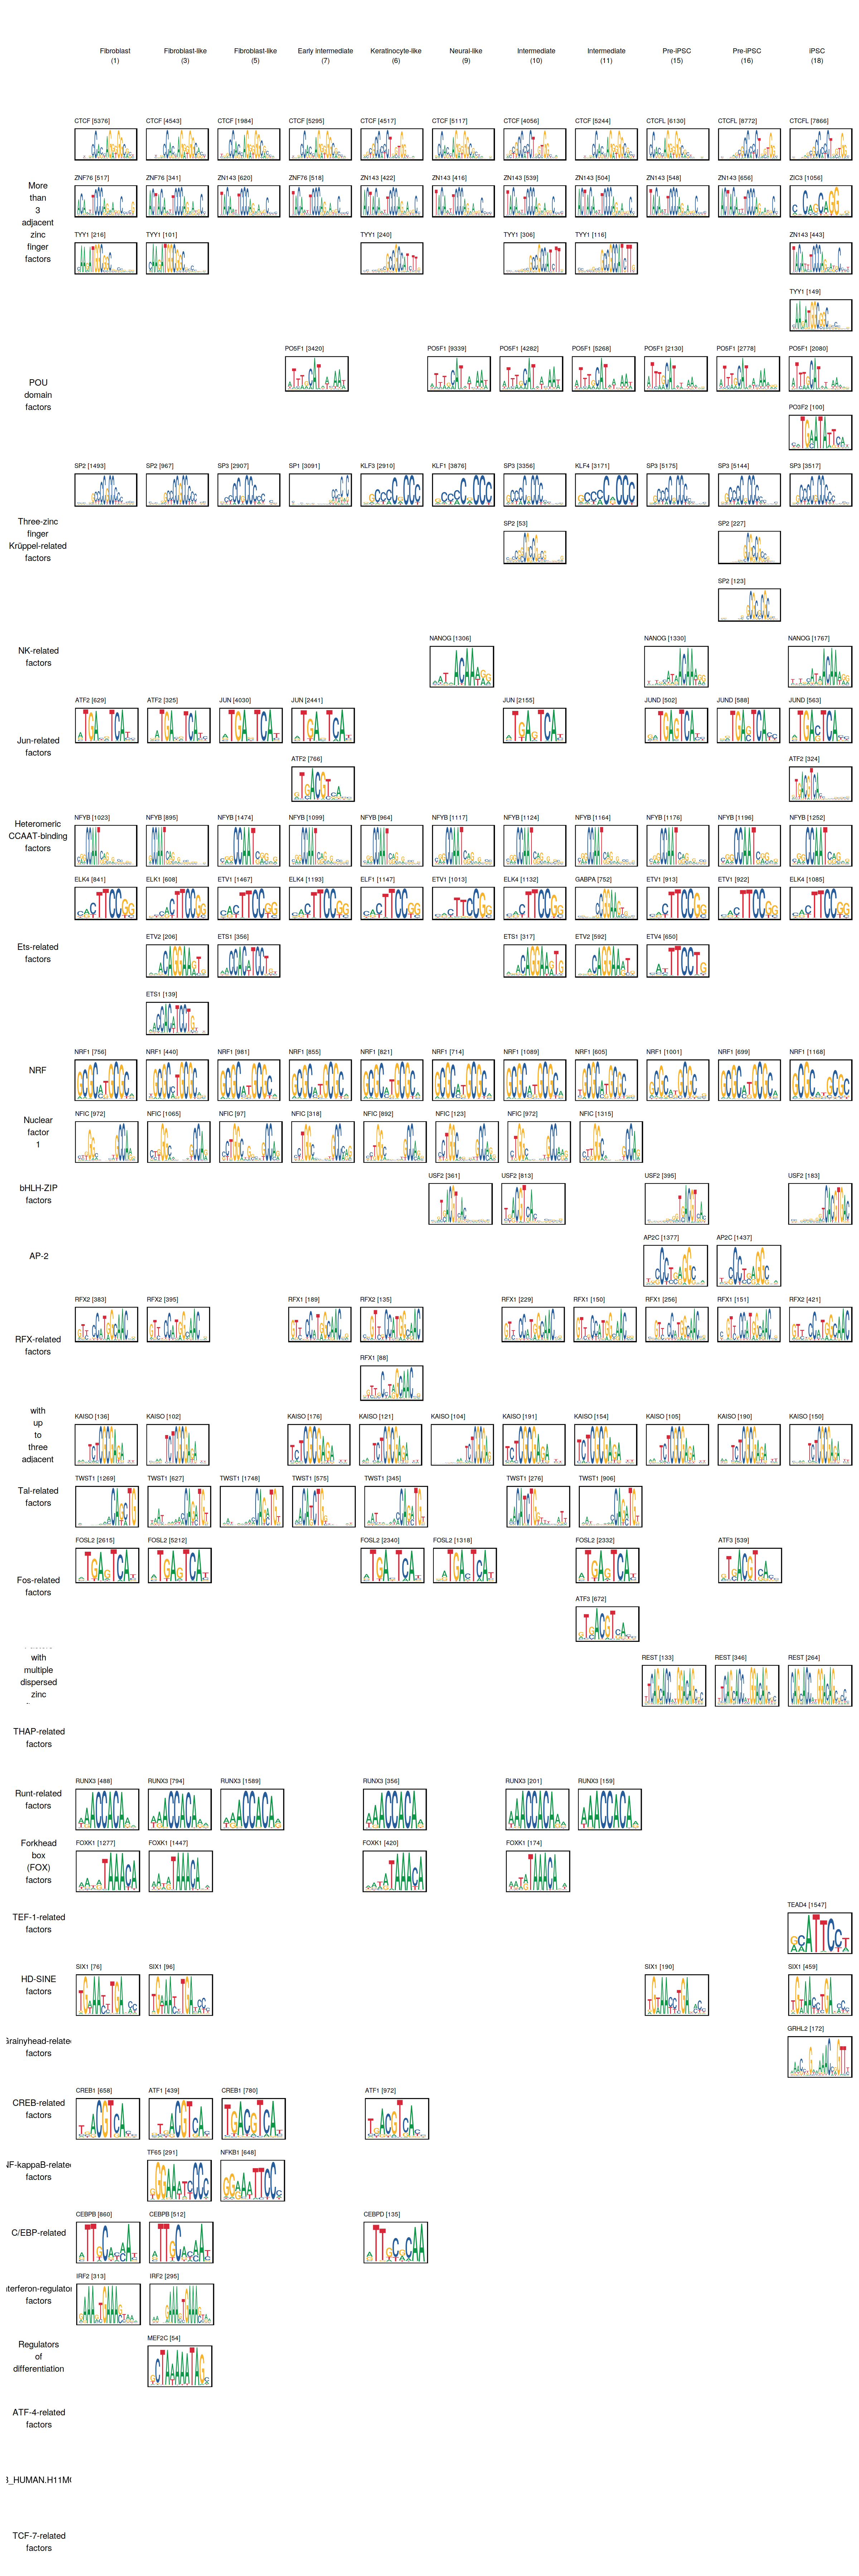

In [624]:
options(repr.plot.width = 20, repr.plot.height = 60)
combined_plot

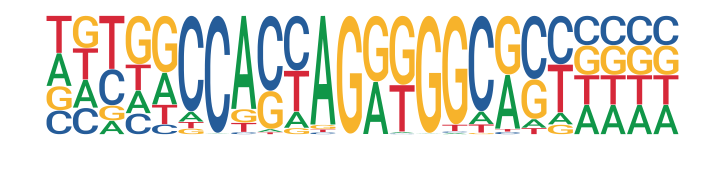

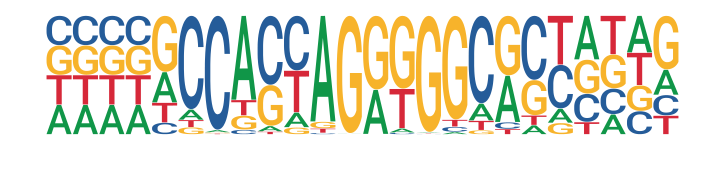

In [517]:
options(repr.plot.width = 6, repr.plot.height = 1.5)
get_motif_plot(get_rev_comp(pfms[["cluster_idx6"]][["pattern_0"]]), pad_right=4, method='prob')
get_motif_plot(get_rev_comp(pfms[["cluster_idx18"]][["pattern_0"]]), pad_left=4, method='prob')